<a href="https://colab.research.google.com/github/aiscience-22/UA_War/blob/olgap%2Fmachine_learning_0.06/linear_regression_for_all_tweets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

In [3]:
spark_version = 'spark-3.2.2'
os.environ['SPARK_VERSION']=spark_version

# Install Spark and Java
!apt-get update
!apt-get install openjdk-11-jdk-headless -qq > /dev/null
!wget -q http://www.apache.org/dist/spark/$SPARK_VERSION/$SPARK_VERSION-bin-hadoop2.7.tgz
!tar xf $SPARK_VERSION-bin-hadoop2.7.tgz
!pip install -q findspark

# Set Environment Variables
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["SPARK_HOME"] = f"/content/{spark_version}-bin-hadoop2.7"

# Start a SparkSession
import findspark
findspark.init()

Get:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:2 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:3 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:6 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:7 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:8 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ Packages [91.7 kB]
Get:9 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Get:10 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Hit:11 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Get:13 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease [15.9 kB]
Get:14 http:

In [5]:
# Add drivers to Spark
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("CloudETL").config("spark.driver.extraClassPath","/content/postgresql-42.2.16.jar").getOrCreate()

# Read the CSV and Perform Basic Data Cleaning

In [44]:
# Read in data from S3 Buckets
from pyspark import SparkFiles
url ="https://uaresources.s3.us-west-1.amazonaws.com/sentiment_joined_events_twitter_post_ml.csv"

spark.sparkContext.addFile(url)
joined_data_df = spark.read.csv(SparkFiles.get("sentiment_joined_events_twitter_post_ml.csv"), sep=",", header=True, inferSchema=True)


# Show DataFrame
joined_data_df.show()

+---+---------------+---------+---------+-----------+-------------+--------------+------------+--------------------+--------+--------------+----------+---------------+-----------+----------+--------------+-------------+-------+--------------------+--------------------+--------------------+--------------------+
|_c0|       username|following|followers|totaltweets|usercreatedts|tweetcreatedts|retweetcount|            hashtags|language|favorite_count|is_retweet|is_quote_status|extractedts|weekofyear|date_published|search_result| weight|        cleaned_text|            negative|             neutral|            positive|
+---+---------------+---------+---------+-----------+-------------+--------------+------------+--------------------+--------+--------------+----------+---------------+-----------+----------+--------------+-------------+-------+--------------------+--------------------+--------------------+--------------------+
|  0|      WashTimes|   1893.0| 417389.0|   335685.0|   2008-05-

In [45]:
# convert spark dataframe to pandas
joined_data_df = joined_data_df.toPandas()
joined_data_df.head(5)




,_c0,username,following,followers,totaltweets,usercreatedts,tweetcreatedts,retweetcount,hashtags,language,...,is_quote_status,extractedts,weekofyear,date_published,search_result,weight,cleaned_text,negative,neutral,positive
0,0,WashTimes,1893.0,417389.0,335685.0,2008-05-05,2022-02-26,0.0,"[{'text': 'UkraineCrisis', 'indices': [102, 11...",en,...,None,2022-02-26,8.0,2022-02-26,106000.0,0.000533,democrats urge biden to counter pain at pump w...,0.222473,0.747085,0.030443
1,1,jacarroll,64.0,254.0,110.0,2008-01-07,2022-02-26,0.0,"[{'text': 'StandWithUkriane', 'indices': [58, ...",en,...,None,2022-02-26,8.0,2022-02-26,106000.0,0.000533,now is the time to annex cuba just sayin,0.078324,0.799905,0.121771
2,2,axelk,5766.0,5329.0,119448.0,2007-06-14,2022-02-26,4.0,[],en,...,None,2022-02-26,8.0,2022-02-26,106000.0,0.000533,just grasping at straws here but does anyone h...,0.147500,0.824443,0.028057
3,3,ds2719,294.0,172.0,15270.0,2007-07-21,2022-02-26,894.0,[],en,...,None,2022-02-26,8.0,2022-02-26,106000.0,0.000533,this is huge russia will be expelled from the ...,0.883955,0.109929,0.006116
4,4,scholar_at_arms,975.0,75.0,1988.0,2008-09-26,2022-02-26,0.0,"[{'text': 'KyivDefiant', 'indices': [18, 30]},...",en,...,None,2022-02-26,8.0,2022-02-26,106000.0,0.000533,please take care,0.063437,0.643451,0.293113


# Cleaning data


In [46]:
# Check data types
joined_data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 713009 entries, 0 to 713008
Data columns (total 22 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   _c0              713009 non-null  int32  
 1   username         713008 non-null  object 
 2   following        713008 non-null  float64
 3   followers        713008 non-null  float64
 4   totaltweets      713008 non-null  float64
 5   usercreatedts    713008 non-null  object 
 6   tweetcreatedts   713008 non-null  object 
 7   retweetcount     713008 non-null  float64
 8   hashtags         713008 non-null  object 
 9   language         713008 non-null  object 
 10  favorite_count   713008 non-null  float64
 11  is_retweet       344456 non-null  object 
 12  is_quote_status  344456 non-null  object 
 13  extractedts      713008 non-null  object 
 14  weekofyear       713008 non-null  float64
 15  date_published   710367 non-null  object 
 16  search_result    710367 non-null  floa

In [47]:
joined_data_df.shape

(713009, 22)

In [48]:
#Check the null values
for column in joined_data_df.columns:
    print(f'Column {column} has {joined_data_df[column].isnull().sum()} null values')

Column _c0 has 0 null values
Column username has 1 null values
Column following has 1 null values
Column followers has 1 null values
Column totaltweets has 1 null values
Column usercreatedts has 1 null values
Column tweetcreatedts has 1 null values
Column retweetcount has 1 null values
Column hashtags has 1 null values
Column language has 1 null values
Column favorite_count has 1 null values
Column is_retweet has 368553 null values
Column is_quote_status has 368553 null values
Column extractedts has 1 null values
Column weekofyear has 1 null values
Column date_published has 2642 null values
Column search_result has 2642 null values
Column weight has 2642 null values
Column cleaned_text has 11 null values
Column negative has 0 null values
Column neutral has 0 null values
Column positive has 0 null values


In [49]:
# Change object type to boolean for columns 'is_retweet' and 'is_quote_status'
joined_data_df["is_retweet"] = joined_data_df['is_retweet'].astype(bool)
joined_data_df["is_quote_status"] = joined_data_df['is_quote_status'].astype(bool)

In [50]:
# drop the row with any NaT values in the tweetcreatedts column
joined_data_df = joined_data_df.dropna(axis=0, subset=['tweetcreatedts'])

In [51]:
# convert text to text lenght
joined_data_df['text_length']  = joined_data_df['cleaned_text'].str.len()
# Drop the columns with text values
joined_data_df.drop("cleaned_text", axis=1, inplace=True)

joined_data_df.head(5)

,_c0,username,following,followers,totaltweets,usercreatedts,tweetcreatedts,retweetcount,hashtags,language,...,is_quote_status,extractedts,weekofyear,date_published,search_result,weight,negative,neutral,positive,text_length
0,0,WashTimes,1893.0,417389.0,335685.0,2008-05-05,2022-02-26,0.0,"[{'text': 'UkraineCrisis', 'indices': [102, 11...",en,...,False,2022-02-26,8.0,2022-02-26,106000.0,0.000533,0.222473,0.747085,0.030443,77.0
1,1,jacarroll,64.0,254.0,110.0,2008-01-07,2022-02-26,0.0,"[{'text': 'StandWithUkriane', 'indices': [58, ...",en,...,False,2022-02-26,8.0,2022-02-26,106000.0,0.000533,0.078324,0.799905,0.121771,40.0
2,2,axelk,5766.0,5329.0,119448.0,2007-06-14,2022-02-26,4.0,[],en,...,False,2022-02-26,8.0,2022-02-26,106000.0,0.000533,0.147500,0.824443,0.028057,138.0
3,3,ds2719,294.0,172.0,15270.0,2007-07-21,2022-02-26,894.0,[],en,...,False,2022-02-26,8.0,2022-02-26,106000.0,0.000533,0.883955,0.109929,0.006116,220.0
4,4,scholar_at_arms,975.0,75.0,1988.0,2008-09-26,2022-02-26,0.0,"[{'text': 'KyivDefiant', 'indices': [18, 30]},...",en,...,False,2022-02-26,8.0,2022-02-26,106000.0,0.000533,0.063437,0.643451,0.293113,16.0


In [52]:
# Drop the not meaningful columns
joined_data_df.drop("username", axis=1, inplace=True)
joined_data_df.drop("usercreatedts", axis=1, inplace=True)
joined_data_df.drop("language", axis=1, inplace=True)
joined_data_df.drop("favorite_count", axis=1, inplace=True)
joined_data_df.drop("extractedts", axis=1, inplace=True)
joined_data_df.drop("weekofyear", axis=1, inplace=True)
joined_data_df.drop("neutral", axis=1, inplace=True)
joined_data_df.drop("positive", axis=1, inplace=True)
joined_data_df.drop("search_result", axis=1, inplace=True)
joined_data_df.drop("retweetcount", axis=1, inplace=True)
joined_data_df.drop("hashtags", axis=1, inplace=True)
joined_data_df.drop("date_published", axis=1, inplace=True)

# convert datetime to numerical
# importing the datetime module
import datetime as dt
joined_data_df['tweetcreatedts'] = pd.to_datetime(joined_data_df['tweetcreatedts'])
joined_data_df['tweetcreatedts'] = joined_data_df['tweetcreatedts'].map(dt.datetime.toordinal)

In [53]:
joined_data_df.shape

(713008, 10)

In [43]:
# Check data types again
joined_data_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 713008 entries, 0 to 713007
Data columns (total 11 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   _c0              713008 non-null  int32  
 1   following        713008 non-null  float64
 2   followers        713008 non-null  float64
 3   totaltweets      713008 non-null  float64
 4   usercreatedts    713008 non-null  object 
 5   tweetcreatedts   713008 non-null  int64  
 6   is_retweet       713008 non-null  bool   
 7   is_quote_status  713008 non-null  bool   
 8   weight           710366 non-null  float64
 9   negative         713008 non-null  float64
 10  text_length      712997 non-null  float64
dtypes: bool(2), float64(6), int32(1), int64(1), object(1)
memory usage: 53.0+ MB


In [54]:
# Drop the data from August 12 till 18 where aren't news data
joined_data_df = joined_data_df.dropna()
joined_data_df.shape

(710355, 10)

In [55]:
joined_data_df.head()

,_c0,following,followers,totaltweets,tweetcreatedts,is_retweet,is_quote_status,weight,negative,text_length
0,0,1893.0,417389.0,335685.0,738212,False,False,0.000533,0.222473,77.0
1,1,64.0,254.0,110.0,738212,False,False,0.000533,0.078324,40.0
2,2,5766.0,5329.0,119448.0,738212,False,False,0.000533,0.147500,138.0
3,3,294.0,172.0,15270.0,738212,False,False,0.000533,0.883955,220.0
4,4,975.0,75.0,1988.0,738212,False,False,0.000533,0.063437,16.0


# Linear regression


We assume that we can predict emotional importance of the events of war by the sentiment analysis of tweets. For first segment we use for that simple linear regression, but at the next segment we could try to make clasterisation for Twitter users for more accurate trend prediction.

Our mockup dataset has data for two days only from 180 days of war yet. This is due to the duration of the calculation of sentiment analysis data: even for that two days it took 6 hours to get the result due to size of twitter data.

In [59]:
# Format the data to meet the requirements of the Scikit-learn library
# Examine the first five entries in X
X = joined_data_df.weight.values.reshape(-1, 1)
X[:5]

array([[0.000533],
       [0.000533],
       [0.000533],
       [0.000533],
       [0.000533]])

In [60]:
# What is the shape of X - rows and columns
X.shape

(710355, 1)

In [61]:
# Assign the target variable, or the Weight column, to y. 
# It's possible to reshape this column, as we did with X, it's not required in this instance
y = joined_data_df.negative
y[:5]

0    0.222473
1    0.078324
2    0.147500
3    0.883955
4    0.063437
Name: negative, dtype: float64

In [62]:
# What is the shape of y - rows and columns
y.shape

(710355,)

In [63]:
# Create an instance of the linear regression model
# That will analyze the data and store information specific to this dataset
model = LinearRegression()
model.fit(X,y)

LinearRegression()

In [64]:
# Generate predictions
y_pred = model.predict(X)
print(y_pred.shape)

(710355,)


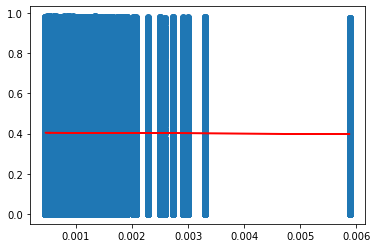

In [65]:
# Plot the predictions as a red line against the data points
plt.scatter(X, y)
plt.plot(X, y_pred, color='red')
plt.show()

In [66]:
# Examine the specific parameters of our model: the slope and the y-intercept
print(model.coef_)
print(model.intercept_)

[-1.28734975]
0.40512304558371576
